# The weather dataset
This tutorial uses a [weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
%load_ext tensorboard


In [2]:
import tensorflow as tf
import datetime

from lstm_timeseries import (data_proc, 
                             univariate_data, 
                             show_plot, 
                             baseline, 
                             multivariate_data,
                             single_step_model, 
                             TimeSeriesLSTM, 
                             plot_preds, 
                             train_val_tf)

import matplotlib.pyplot as plt
tf.random.set_seed(13)



In [3]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [4]:
%%time
df = data_proc()

Wall time: 1.13 s


In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
TRAIN_SPLIT = 300000


# Part 1: Forecast a univariate time series

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

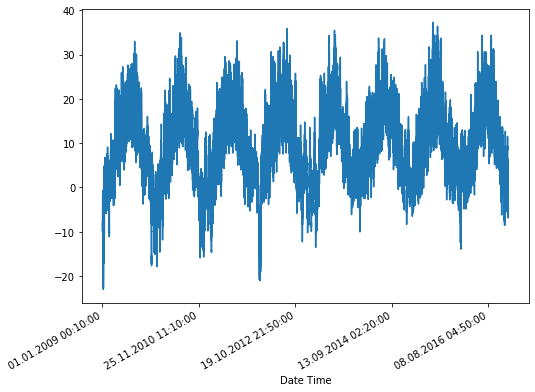

In [8]:
uni_data.plot(subplots=True);

In [9]:
uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std


univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

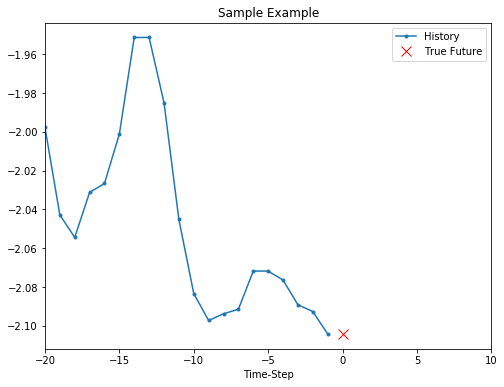

In [10]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

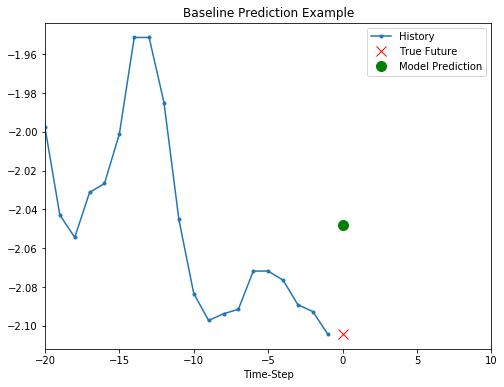

In [11]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example');

# Multivariate forecast with lstm

In [12]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


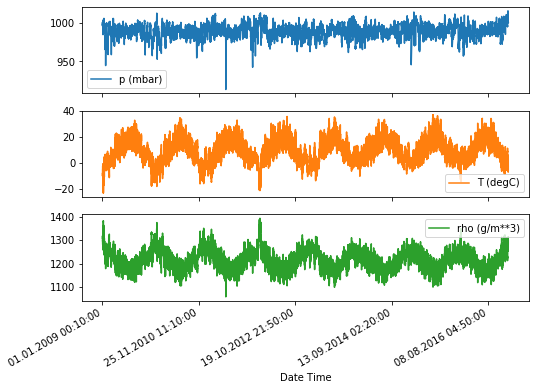

In [13]:
features.plot(subplots=True);

In [14]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset - data_mean)/data_std

# Single step model
* multivariate features to predict next time step

In [15]:
# data for the last 5 days is used (720 observations) predict 12h ahead
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)



In [16]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [17]:
%%time
trained_model, single_step_history = single_step_model(x_train_single, 
                                                       y_train_single,
                                                       x_val_single, 
                                                       y_val_single,
                                                       epochs=4)



Train for 200 steps, validate for 50 steps
Epoch 1/2
200/200 [==============================] - ETA: 12:14 - loss: 1.13 - ETA: 2:01 - loss: 0.9627 - ETA: 1:05 - loss: 0.795 - ETA: 44s - loss: 0.663 - ETA: 33s - loss: 0.59 - ETA: 26s - loss: 0.55 - ETA: 21s - loss: 0.52 - ETA: 18s - loss: 0.50 - ETA: 15s - loss: 0.48 - ETA: 13s - loss: 0.47 - ETA: 11s - loss: 0.45 - ETA: 10s - loss: 0.44 - ETA: 9s - loss: 0.4315 - ETA: 8s - loss: 0.421 - ETA: 7s - loss: 0.410 - ETA: 6s - loss: 0.403 - ETA: 5s - loss: 0.394 - ETA: 5s - loss: 0.386 - ETA: 4s - loss: 0.379 - ETA: 4s - loss: 0.373 - ETA: 3s - loss: 0.367 - ETA: 3s - loss: 0.362 - ETA: 3s - loss: 0.358 - ETA: 2s - loss: 0.356 - ETA: 2s - loss: 0.352 - ETA: 2s - loss: 0.348 - ETA: 1s - loss: 0.344 - ETA: 1s - loss: 0.340 - ETA: 1s - loss: 0.337 - ETA: 1s - loss: 0.335 - ETA: 0s - loss: 0.334 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.325 - 7s 33ms/step - loss: 0.3251 - v

# Plot first 3 predictions
Use validation data for predictions

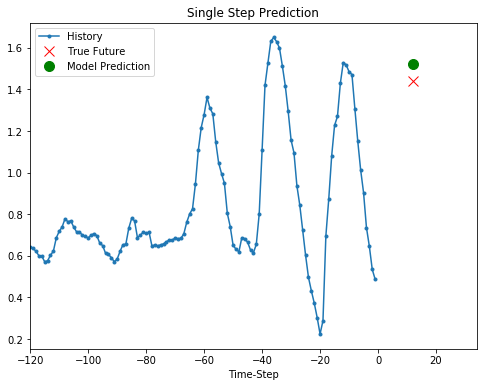

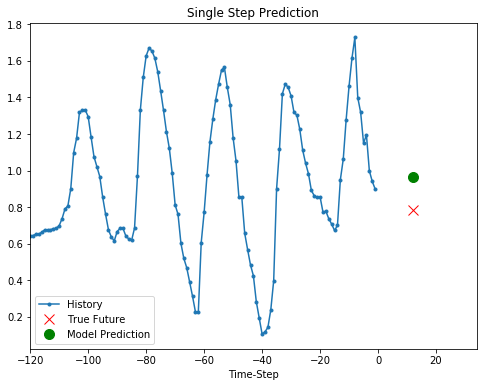

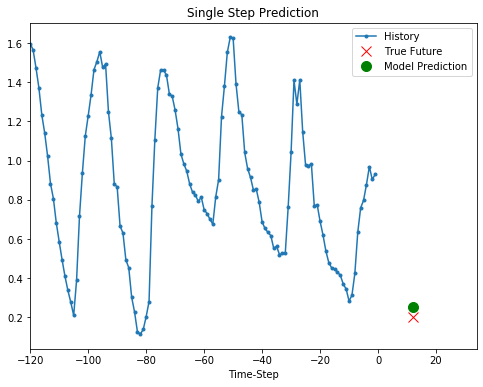

In [18]:

train_data_single, val_data_single = train_val_tf(x_train_single, y_train_single, x_val_single, y_val_single)
plot_preds(trained_model, val_data_single)



In [19]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

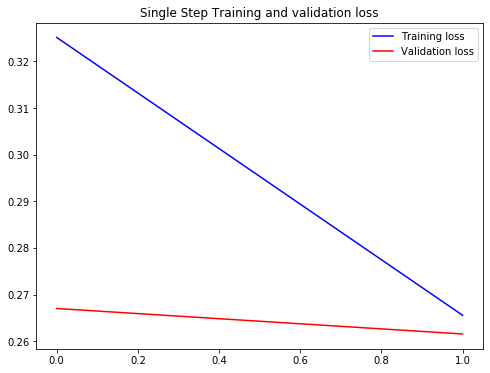

In [20]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Hyperparam search
### Hyperband
* Same data as in single step training above

In [21]:
%%time
from kerastuner.tuners import RandomSearch, Hyperband


hypermodel = TimeSeriesLSTM(num_outputs=1)
    
tuner = Hyperband(
    hypermodel,
    objective='mae',
    #max_trials=40,
    directory='hyperband',
    project_name='helloworld_hyperband', 
    max_epochs=4)



tuner.search(x_train_single,
             y_train_single, 
             epochs=4, 
             validation_data=(x_val_single, y_val_single))

INFO:tensorflow:Reloading Oracle from existing project hyperband\helloworld_hyperband\oracle.json
INFO:tensorflow:Reloading Tuner from hyperband\helloworld_hyperband\tuner0.json
INFO:tensorflow:Oracle triggered exit
Wall time: 377 ms


In [22]:
models = tuner.get_best_models(num_models=1)

In [23]:
tuner.results_summary()

In [24]:
models

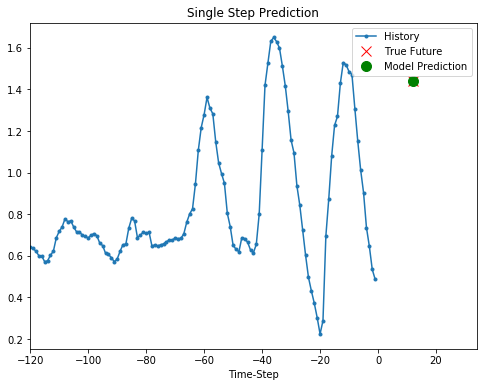

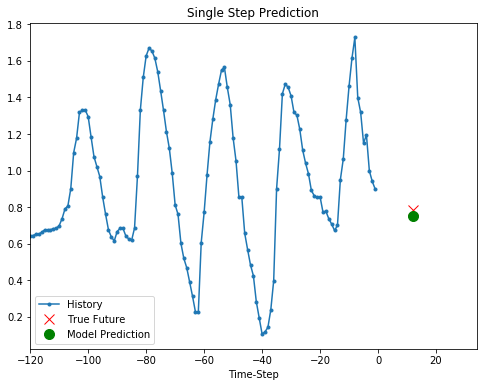

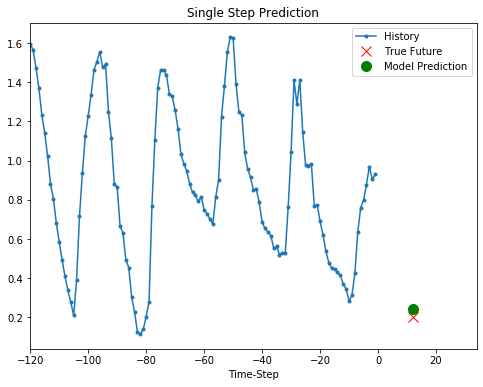

In [30]:
plot_preds(models[0], val_data_single)

tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
#loss, accuracy = best_model.evaluate(x_val_single, y_val_single)

#  Random Search

In [26]:
%%time

randommodel = TimeSeriesLSTM(num_outputs=1)

random_tuner = RandomSearch(
    randommodel,
    objective='mae',
    max_trials=4,
    directory='random_search',
    project_name='helloworld_random')

random_tuner.search(x_train_single,
                    y_train_single, 
                    epochs=4, 
                    validation_data=(x_val_single, y_val_single), )

INFO:tensorflow:Reloading Oracle from existing project random_search\helloworld_random\oracle.json
Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 38112/299280 [==>...........................] - ETA: 4:29:50 - loss: 0.6057 - mae: 0.60 - ETA: 39:48 - loss: 0.6802 - mae: 0.6802 - ETA: 22:06 - loss: 0.6551 - mae: 0.65 - ETA: 15:34 - loss: 0.6395 - mae: 0.63 - ETA: 12:39 - loss: 0.6189 - mae: 0.61 - ETA: 10:25 - loss: 0.6016 - mae: 0.60 - ETA: 8:55 - loss: 0.5873 - mae: 0.5873 - ETA: 7:51 - loss: 0.5750 - mae: 0.575 - ETA: 7:02 - loss: 0.5577 - mae: 0.557 - ETA: 6:25 - loss: 0.5458 - mae: 0.545 - ETA: 6:00 - loss: 0.5351 - mae: 0.535 - ETA: 5:35 - loss: 0.5246 - mae: 0.524 - ETA: 5:14 - loss: 0.5162 - mae: 0.516 - ETA: 4:57 - loss: 0.5080 - mae: 0.508 - ETA: 4:41 - loss: 0.4980 - mae: 0.498 - ETA: 4:28 - loss: 0.4887 - mae: 0.488 - ETA: 4:16 - loss: 0.4806 - mae: 0.480 - ETA: 4:06 - loss: 0.4741 - mae: 0.474 - ETA: 3:57 - loss: 0.4695 - mae: 0.469 - ETA: 3:49 - loss: 0.4645 - mae: 0.464 - ETA: 3:42 - loss: 0.4597 - mae: 0.459 - ETA: 3:35 - loss: 0.4552 - mae: 0.455 - ETA: 3:29 - loss: 0.4502 - mae: 0.450 - ETA: 3:23 - loss: 0.4472 -

 76640/299280 [======>.......................] - ETA: 1:29 - loss: 0.3178 - mae: 0.317 - ETA: 1:29 - loss: 0.3177 - mae: 0.317 - ETA: 1:29 - loss: 0.3175 - mae: 0.317 - ETA: 1:29 - loss: 0.3174 - mae: 0.317 - ETA: 1:28 - loss: 0.3171 - mae: 0.317 - ETA: 1:28 - loss: 0.3170 - mae: 0.317 - ETA: 1:28 - loss: 0.3168 - mae: 0.316 - ETA: 1:28 - loss: 0.3165 - mae: 0.316 - ETA: 1:28 - loss: 0.3165 - mae: 0.316 - ETA: 1:28 - loss: 0.3163 - mae: 0.316 - ETA: 1:28 - loss: 0.3161 - mae: 0.316 - ETA: 1:28 - loss: 0.3159 - mae: 0.315 - ETA: 1:27 - loss: 0.3157 - mae: 0.315 - ETA: 1:27 - loss: 0.3155 - mae: 0.315 - ETA: 1:27 - loss: 0.3153 - mae: 0.315 - ETA: 1:27 - loss: 0.3153 - mae: 0.315 - ETA: 1:27 - loss: 0.3151 - mae: 0.315 - ETA: 1:27 - loss: 0.3149 - mae: 0.314 - ETA: 1:27 - loss: 0.3148 - mae: 0.314 - ETA: 1:27 - loss: 0.3147 - mae: 0.314 - ETA: 1:26 - loss: 0.3145 - mae: 0.314 - ETA: 1:26 - loss: 0.3145 - mae: 0.314 - ETA: 1:26 - loss: 0.3142 - mae: 0.314 - ETA: 1:26 - loss: 0.3139 - mae:

116288/299280 [==========>...................] - ETA: 1:10 - loss: 0.2954 - mae: 0.295 - ETA: 1:10 - loss: 0.2952 - mae: 0.295 - ETA: 1:10 - loss: 0.2952 - mae: 0.295 - ETA: 1:10 - loss: 0.2951 - mae: 0.295 - ETA: 1:10 - loss: 0.2950 - mae: 0.295 - ETA: 1:10 - loss: 0.2950 - mae: 0.295 - ETA: 1:10 - loss: 0.2949 - mae: 0.294 - ETA: 1:10 - loss: 0.2948 - mae: 0.294 - ETA: 1:10 - loss: 0.2947 - mae: 0.294 - ETA: 1:10 - loss: 0.2946 - mae: 0.294 - ETA: 1:10 - loss: 0.2946 - mae: 0.294 - ETA: 1:10 - loss: 0.2945 - mae: 0.294 - ETA: 1:09 - loss: 0.2944 - mae: 0.294 - ETA: 1:09 - loss: 0.2944 - mae: 0.294 - ETA: 1:09 - loss: 0.2943 - mae: 0.294 - ETA: 1:09 - loss: 0.2942 - mae: 0.294 - ETA: 1:09 - loss: 0.2942 - mae: 0.294 - ETA: 1:09 - loss: 0.2942 - mae: 0.294 - ETA: 1:09 - loss: 0.2940 - mae: 0.294 - ETA: 1:09 - loss: 0.2940 - mae: 0.294 - ETA: 1:09 - loss: 0.2939 - mae: 0.293 - ETA: 1:09 - loss: 0.2938 - mae: 0.293 - ETA: 1:09 - loss: 0.2937 - mae: 0.293 - ETA: 1:09 - loss: 0.2936 - mae:

156576/299280 [==============>...............] - ETA: 56s - loss: 0.2840 - mae: 0.28 - ETA: 56s - loss: 0.2839 - mae: 0.28 - ETA: 56s - loss: 0.2839 - mae: 0.28 - ETA: 56s - loss: 0.2838 - mae: 0.28 - ETA: 56s - loss: 0.2838 - mae: 0.28 - ETA: 56s - loss: 0.2838 - mae: 0.28 - ETA: 56s - loss: 0.2837 - mae: 0.28 - ETA: 56s - loss: 0.2837 - mae: 0.28 - ETA: 56s - loss: 0.2836 - mae: 0.28 - ETA: 56s - loss: 0.2836 - mae: 0.28 - ETA: 55s - loss: 0.2836 - mae: 0.28 - ETA: 55s - loss: 0.2836 - mae: 0.28 - ETA: 55s - loss: 0.2835 - mae: 0.28 - ETA: 55s - loss: 0.2835 - mae: 0.28 - ETA: 55s - loss: 0.2835 - mae: 0.28 - ETA: 55s - loss: 0.2834 - mae: 0.28 - ETA: 55s - loss: 0.2834 - mae: 0.28 - ETA: 55s - loss: 0.2834 - mae: 0.28 - ETA: 55s - loss: 0.2833 - mae: 0.28 - ETA: 55s - loss: 0.2833 - mae: 0.28 - ETA: 55s - loss: 0.2832 - mae: 0.28 - ETA: 55s - loss: 0.2832 - mae: 0.28 - ETA: 55s - loss: 0.2832 - mae: 0.28 - ETA: 55s - loss: 0.2830 - mae: 0.28 - ETA: 55s - loss: 0.2830 - mae: 0.28 - E

197824/299280 [==================>...........] - ETA: 43s - loss: 0.2764 - mae: 0.27 - ETA: 43s - loss: 0.2764 - mae: 0.27 - ETA: 43s - loss: 0.2764 - mae: 0.27 - ETA: 43s - loss: 0.2764 - mae: 0.27 - ETA: 43s - loss: 0.2763 - mae: 0.27 - ETA: 43s - loss: 0.2763 - mae: 0.27 - ETA: 43s - loss: 0.2762 - mae: 0.27 - ETA: 43s - loss: 0.2762 - mae: 0.27 - ETA: 43s - loss: 0.2762 - mae: 0.27 - ETA: 43s - loss: 0.2761 - mae: 0.27 - ETA: 43s - loss: 0.2761 - mae: 0.27 - ETA: 42s - loss: 0.2761 - mae: 0.27 - ETA: 42s - loss: 0.2761 - mae: 0.27 - ETA: 42s - loss: 0.2760 - mae: 0.27 - ETA: 42s - loss: 0.2760 - mae: 0.27 - ETA: 42s - loss: 0.2760 - mae: 0.27 - ETA: 42s - loss: 0.2760 - mae: 0.27 - ETA: 42s - loss: 0.2760 - mae: 0.27 - ETA: 42s - loss: 0.2760 - mae: 0.27 - ETA: 42s - loss: 0.2759 - mae: 0.27 - ETA: 42s - loss: 0.2759 - mae: 0.27 - ETA: 42s - loss: 0.2759 - mae: 0.27 - ETA: 42s - loss: 0.2758 - mae: 0.27 - ETA: 42s - loss: 0.2758 - mae: 0.27 - ETA: 42s - loss: 0.2758 - mae: 0.27 - E

239040/299280 [======================>.......] - ETA: 30s - loss: 0.2714 - mae: 0.27 - ETA: 30s - loss: 0.2714 - mae: 0.27 - ETA: 30s - loss: 0.2713 - mae: 0.27 - ETA: 30s - loss: 0.2713 - mae: 0.27 - ETA: 30s - loss: 0.2713 - mae: 0.27 - ETA: 30s - loss: 0.2713 - mae: 0.27 - ETA: 30s - loss: 0.2712 - mae: 0.27 - ETA: 30s - loss: 0.2712 - mae: 0.27 - ETA: 30s - loss: 0.2712 - mae: 0.27 - ETA: 30s - loss: 0.2712 - mae: 0.27 - ETA: 30s - loss: 0.2712 - mae: 0.27 - ETA: 30s - loss: 0.2712 - mae: 0.27 - ETA: 30s - loss: 0.2712 - mae: 0.27 - ETA: 29s - loss: 0.2711 - mae: 0.27 - ETA: 29s - loss: 0.2711 - mae: 0.27 - ETA: 29s - loss: 0.2711 - mae: 0.27 - ETA: 29s - loss: 0.2711 - mae: 0.27 - ETA: 29s - loss: 0.2711 - mae: 0.27 - ETA: 29s - loss: 0.2711 - mae: 0.27 - ETA: 29s - loss: 0.2711 - mae: 0.27 - ETA: 29s - loss: 0.2710 - mae: 0.27 - ETA: 29s - loss: 0.2710 - mae: 0.27 - ETA: 29s - loss: 0.2710 - mae: 0.27 - ETA: 29s - loss: 0.2710 - mae: 0.27 - ETA: 29s - loss: 0.2710 - mae: 0.27 - E

280128/299280 [===========================>..] - ETA: 18s - loss: 0.2673 - mae: 0.26 - ETA: 18s - loss: 0.2673 - mae: 0.26 - ETA: 17s - loss: 0.2673 - mae: 0.26 - ETA: 17s - loss: 0.2673 - mae: 0.26 - ETA: 17s - loss: 0.2673 - mae: 0.26 - ETA: 17s - loss: 0.2672 - mae: 0.26 - ETA: 17s - loss: 0.2672 - mae: 0.26 - ETA: 17s - loss: 0.2672 - mae: 0.26 - ETA: 17s - loss: 0.2672 - mae: 0.26 - ETA: 17s - loss: 0.2671 - mae: 0.26 - ETA: 17s - loss: 0.2671 - mae: 0.26 - ETA: 17s - loss: 0.2671 - mae: 0.26 - ETA: 17s - loss: 0.2671 - mae: 0.26 - ETA: 17s - loss: 0.2671 - mae: 0.26 - ETA: 17s - loss: 0.2670 - mae: 0.26 - ETA: 17s - loss: 0.2670 - mae: 0.26 - ETA: 17s - loss: 0.2670 - mae: 0.26 - ETA: 17s - loss: 0.2670 - mae: 0.26 - ETA: 17s - loss: 0.2670 - mae: 0.26 - ETA: 16s - loss: 0.2670 - mae: 0.26 - ETA: 16s - loss: 0.2670 - mae: 0.26 - ETA: 16s - loss: 0.2669 - mae: 0.26 - ETA: 16s - loss: 0.2669 - mae: 0.26 - ETA: 16s - loss: 0.2669 - mae: 0.26 - ETA: 16s - loss: 0.2669 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 5s - loss: 0.2646 - mae: 0.264 - ETA: 5s - loss: 0.2646 - mae: 0.264 - ETA: 5s - loss: 0.2646 - mae: 0.264 - ETA: 5s - loss: 0.2645 - mae: 0.264 - ETA: 5s - loss: 0.2645 - mae: 0.264 - ETA: 5s - loss: 0.2645 - mae: 0.264 - ETA: 5s - loss: 0.2645 - mae: 0.264 - ETA: 5s - loss: 0.2645 - mae: 0.264 - ETA: 5s - loss: 0.2645 - mae: 0.264 - ETA: 5s - loss: 0.2645 - mae: 0.264 - ETA: 5s - loss: 0.2645 - mae: 0.264 - ETA: 5s - loss: 0.2645 - mae: 0.264 - ETA: 4s - loss: 0.2644 - mae: 0.264 - ETA: 4s - loss: 0.2644 - mae: 0.264 - ETA: 4s - loss: 0.2644 - mae: 0.264 - ETA: 4s - loss: 0.2644 - mae: 0.264 - ETA: 4s - loss: 0.2644 - mae: 0.264 - ETA: 4s - loss: 0.2644 - mae: 0.264 - ETA: 4s - loss: 0.2644 - mae: 0.264 - ETA: 4s - loss: 0.2644 - mae: 0.264 - ETA: 4s - loss: 0.2644 - mae: 0.264 - ETA: 4s - loss: 0.2644 - mae: 0.264 - ETA: 4s - loss: 0.2643 - mae: 0.264 - ETA: 4s - loss: 0.2643 - mae: 0.264 - ETA: 4s - loss: 0.2643 - mae: 0.264 - E

 37440/299280 [==>...........................] - ETA: 2:01 - loss: 0.2692 - mae: 0.269 - ETA: 1:50 - loss: 0.2470 - mae: 0.247 - ETA: 1:41 - loss: 0.2412 - mae: 0.241 - ETA: 1:37 - loss: 0.2363 - mae: 0.236 - ETA: 1:35 - loss: 0.2466 - mae: 0.246 - ETA: 1:36 - loss: 0.2441 - mae: 0.244 - ETA: 1:37 - loss: 0.2449 - mae: 0.244 - ETA: 1:37 - loss: 0.2413 - mae: 0.241 - ETA: 1:35 - loss: 0.2433 - mae: 0.243 - ETA: 1:34 - loss: 0.2452 - mae: 0.245 - ETA: 1:34 - loss: 0.2428 - mae: 0.242 - ETA: 1:35 - loss: 0.2431 - mae: 0.243 - ETA: 1:36 - loss: 0.2413 - mae: 0.241 - ETA: 1:36 - loss: 0.2425 - mae: 0.242 - ETA: 1:35 - loss: 0.2434 - mae: 0.243 - ETA: 1:35 - loss: 0.2425 - mae: 0.242 - ETA: 1:35 - loss: 0.2431 - mae: 0.243 - ETA: 1:34 - loss: 0.2436 - mae: 0.243 - ETA: 1:35 - loss: 0.2432 - mae: 0.243 - ETA: 1:35 - loss: 0.2429 - mae: 0.242 - ETA: 1:35 - loss: 0.2422 - mae: 0.242 - ETA: 1:35 - loss: 0.2421 - mae: 0.242 - ETA: 1:34 - loss: 0.2419 - mae: 0.241 - ETA: 1:34 - loss: 0.2419 - mae:

 75296/299280 [======>.......................] - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2457 - mae: 0.245 - ETA: 1:19 - loss: 0.2457 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:19 - loss: 0.2457 - mae: 0.245 - ETA: 1:19 - loss: 0.2457 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:19 - loss: 0.2457 - mae: 0.245 - ETA: 1:19 - loss: 0.2457 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:19 - loss: 0.2457 - mae: 0.245 - ETA: 1:19 - loss: 0.2457 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:18 - loss: 0.2457 - mae: 0.245 - ETA: 1:18 - loss: 0.2456 - mae: 0.245 - ETA: 1:18 - loss: 0.2456 - mae: 0.245 - ETA: 1:18 - loss: 0.2456 - mae: 0.245 - ETA: 1:18 - loss: 0.2456 - mae: 0.245 - ETA: 1:18 - loss: 0.2456 - mae: 0.245 - ETA: 1:18 - loss: 0.2456 - mae:

113504/299280 [==========>...................] - ETA: 1:08 - loss: 0.2454 - mae: 0.245 - ETA: 1:08 - loss: 0.2454 - mae: 0.245 - ETA: 1:08 - loss: 0.2454 - mae: 0.245 - ETA: 1:08 - loss: 0.2454 - mae: 0.245 - ETA: 1:08 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2455 - mae: 0.245 - ETA: 1:07 - loss: 0.2455 - mae: 0.245 - ETA: 1:07 - loss: 0.2455 - mae: 0.245 - ETA: 1:07 - loss: 0.2455 - mae: 0.245 - ETA: 1:07 - loss: 0.2455 - mae: 0.245 - ETA: 1:07 - loss: 0.2455 - mae: 0.245 - ETA: 1:07 - loss: 0.2456 - mae: 0.245 - ETA: 1:07 - loss: 0.2456 - mae: 0.245 - ETA: 1:07 - loss: 0.2456 - mae: 0.245 - ETA: 1:06 - loss: 0.2456 - mae: 0.245 - ETA: 1:06 - loss: 0.2456 - mae:

153632/299280 [==============>...............] - ETA: 56s - loss: 0.2450 - mae: 0.24 - ETA: 56s - loss: 0.2450 - mae: 0.24 - ETA: 56s - loss: 0.2449 - mae: 0.24 - ETA: 56s - loss: 0.2449 - mae: 0.24 - ETA: 56s - loss: 0.2449 - mae: 0.24 - ETA: 56s - loss: 0.2449 - mae: 0.24 - ETA: 56s - loss: 0.2449 - mae: 0.24 - ETA: 56s - loss: 0.2448 - mae: 0.24 - ETA: 56s - loss: 0.2449 - mae: 0.24 - ETA: 56s - loss: 0.2448 - mae: 0.24 - ETA: 56s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2449 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2449 - mae: 0.24 - ETA: 55s - loss: 0.2449 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - ETA: 55s - loss: 0.2448 - mae: 0.24 - E

193504/299280 [==================>...........] - ETA: 44s - loss: 0.2442 - mae: 0.24 - ETA: 44s - loss: 0.2442 - mae: 0.24 - ETA: 44s - loss: 0.2442 - mae: 0.24 - ETA: 44s - loss: 0.2442 - mae: 0.24 - ETA: 44s - loss: 0.2442 - mae: 0.24 - ETA: 44s - loss: 0.2442 - mae: 0.24 - ETA: 44s - loss: 0.2442 - mae: 0.24 - ETA: 43s - loss: 0.2443 - mae: 0.24 - ETA: 43s - loss: 0.2442 - mae: 0.24 - ETA: 43s - loss: 0.2443 - mae: 0.24 - ETA: 43s - loss: 0.2443 - mae: 0.24 - ETA: 43s - loss: 0.2443 - mae: 0.24 - ETA: 43s - loss: 0.2443 - mae: 0.24 - ETA: 43s - loss: 0.2443 - mae: 0.24 - ETA: 43s - loss: 0.2443 - mae: 0.24 - ETA: 43s - loss: 0.2442 - mae: 0.24 - ETA: 43s - loss: 0.2442 - mae: 0.24 - ETA: 43s - loss: 0.2442 - mae: 0.24 - ETA: 43s - loss: 0.2442 - mae: 0.24 - ETA: 43s - loss: 0.2442 - mae: 0.24 - ETA: 43s - loss: 0.2442 - mae: 0.24 - ETA: 43s - loss: 0.2442 - mae: 0.24 - ETA: 43s - loss: 0.2442 - mae: 0.24 - ETA: 43s - loss: 0.2442 - mae: 0.24 - ETA: 42s - loss: 0.2441 - mae: 0.24 - E

232800/299280 [======================>.......] - ETA: 32s - loss: 0.2436 - mae: 0.24 - ETA: 32s - loss: 0.2436 - mae: 0.24 - ETA: 32s - loss: 0.2436 - mae: 0.24 - ETA: 32s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 31s - loss: 0.2436 - mae: 0.24 - ETA: 30s - loss: 0.2436 - mae: 0.24 - ETA: 30s - loss: 0.2435 - mae: 0.24 - ETA: 30s - loss: 0.2435 - mae: 0.24 - ETA: 30s - loss: 0.2435 - mae: 0.24 - E

273504/299280 [==========================>...] - ETA: 20s - loss: 0.2432 - mae: 0.24 - ETA: 20s - loss: 0.2432 - mae: 0.24 - ETA: 20s - loss: 0.2432 - mae: 0.24 - ETA: 20s - loss: 0.2432 - mae: 0.24 - ETA: 20s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 18s - loss: 0.2432 - mae: 0.24 - ETA: 18s - loss: 0.2432 - mae: 0.24 - ETA: 18s - loss: 0.2432 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 7s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - ETA: 6s - loss: 0.2428 - mae: 0.242 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32128/299280 [==>...........................] - ETA: 4:18:02 - loss: 0.5713 - mae: 0.57 - ETA: 44:33 - loss: 0.5566 - mae: 0.5566 - ETA: 27:32 - loss: 0.5563 - mae: 0.55 - ETA: 18:59 - loss: 0.5064 - mae: 0.50 - ETA: 15:24 - loss: 0.4890 - mae: 0.48 - ETA: 12:33 - loss: 0.4640 - mae: 0.46 - ETA: 10:41 - loss: 0.4415 - mae: 0.44 - ETA: 9:22 - loss: 0.4287 - mae: 0.4287 - ETA: 8:24 - loss: 0.4196 - mae: 0.419 - ETA: 7:38 - loss: 0.4127 - mae: 0.412 - ETA: 7:02 - loss: 0.4082 - mae: 0.408 - ETA: 6:32 - loss: 0.4045 - mae: 0.404 - ETA: 6:08 - loss: 0.3999 - mae: 0.399 - ETA: 5:47 - loss: 0.3989 - mae: 0.398 - ETA: 5:29 - loss: 0.3966 - mae: 0.396 - ETA: 5:13 - loss: 0.3966 - mae: 0.396 - ETA: 5:00 - loss: 0.3956 - mae: 0.395 - ETA: 4:48 - loss: 0.3915 - mae: 0.391 - ETA: 4:37 - loss: 0.3889 - mae: 0.388 - ETA: 4:28 - loss: 0.3861 - mae: 0.386 - ETA: 4:19 - loss: 0.3851 - mae: 0.385 - ETA: 4:12 - loss: 0.3839 - mae: 0.383 - ETA: 4:05 - loss: 0.3824 - mae: 0.382 - ETA: 3:58 - loss: 0.3808 -

 64512/299280 [=====>........................] - ETA: 1:45 - loss: 0.2922 - mae: 0.292 - ETA: 1:45 - loss: 0.2920 - mae: 0.292 - ETA: 1:45 - loss: 0.2918 - mae: 0.291 - ETA: 1:44 - loss: 0.2917 - mae: 0.291 - ETA: 1:44 - loss: 0.2915 - mae: 0.291 - ETA: 1:44 - loss: 0.2914 - mae: 0.291 - ETA: 1:44 - loss: 0.2912 - mae: 0.291 - ETA: 1:44 - loss: 0.2912 - mae: 0.291 - ETA: 1:44 - loss: 0.2910 - mae: 0.291 - ETA: 1:44 - loss: 0.2908 - mae: 0.290 - ETA: 1:44 - loss: 0.2906 - mae: 0.290 - ETA: 1:43 - loss: 0.2905 - mae: 0.290 - ETA: 1:43 - loss: 0.2905 - mae: 0.290 - ETA: 1:43 - loss: 0.2904 - mae: 0.290 - ETA: 1:43 - loss: 0.2903 - mae: 0.290 - ETA: 1:43 - loss: 0.2904 - mae: 0.290 - ETA: 1:43 - loss: 0.2903 - mae: 0.290 - ETA: 1:43 - loss: 0.2902 - mae: 0.290 - ETA: 1:43 - loss: 0.2901 - mae: 0.290 - ETA: 1:42 - loss: 0.2900 - mae: 0.290 - ETA: 1:42 - loss: 0.2899 - mae: 0.289 - ETA: 1:42 - loss: 0.2899 - mae: 0.289 - ETA: 1:42 - loss: 0.2897 - mae: 0.289 - ETA: 1:42 - loss: 0.2895 - mae:

 97152/299280 [========>.....................] - ETA: 1:26 - loss: 0.2758 - mae: 0.275 - ETA: 1:26 - loss: 0.2758 - mae: 0.275 - ETA: 1:26 - loss: 0.2757 - mae: 0.275 - ETA: 1:26 - loss: 0.2756 - mae: 0.275 - ETA: 1:26 - loss: 0.2756 - mae: 0.275 - ETA: 1:26 - loss: 0.2756 - mae: 0.275 - ETA: 1:26 - loss: 0.2756 - mae: 0.275 - ETA: 1:26 - loss: 0.2755 - mae: 0.275 - ETA: 1:26 - loss: 0.2755 - mae: 0.275 - ETA: 1:26 - loss: 0.2754 - mae: 0.275 - ETA: 1:26 - loss: 0.2753 - mae: 0.275 - ETA: 1:26 - loss: 0.2753 - mae: 0.275 - ETA: 1:26 - loss: 0.2751 - mae: 0.275 - ETA: 1:25 - loss: 0.2751 - mae: 0.275 - ETA: 1:25 - loss: 0.2750 - mae: 0.275 - ETA: 1:25 - loss: 0.2750 - mae: 0.275 - ETA: 1:25 - loss: 0.2750 - mae: 0.275 - ETA: 1:25 - loss: 0.2750 - mae: 0.275 - ETA: 1:25 - loss: 0.2749 - mae: 0.274 - ETA: 1:25 - loss: 0.2749 - mae: 0.274 - ETA: 1:25 - loss: 0.2749 - mae: 0.274 - ETA: 1:25 - loss: 0.2748 - mae: 0.274 - ETA: 1:25 - loss: 0.2748 - mae: 0.274 - ETA: 1:25 - loss: 0.2747 - mae:

129792/299280 [============>.................] - ETA: 1:12 - loss: 0.2679 - mae: 0.267 - ETA: 1:12 - loss: 0.2678 - mae: 0.267 - ETA: 1:12 - loss: 0.2678 - mae: 0.267 - ETA: 1:12 - loss: 0.2677 - mae: 0.267 - ETA: 1:12 - loss: 0.2677 - mae: 0.267 - ETA: 1:12 - loss: 0.2677 - mae: 0.267 - ETA: 1:12 - loss: 0.2676 - mae: 0.267 - ETA: 1:12 - loss: 0.2676 - mae: 0.267 - ETA: 1:12 - loss: 0.2676 - mae: 0.267 - ETA: 1:12 - loss: 0.2675 - mae: 0.267 - ETA: 1:12 - loss: 0.2675 - mae: 0.267 - ETA: 1:12 - loss: 0.2675 - mae: 0.267 - ETA: 1:12 - loss: 0.2674 - mae: 0.267 - ETA: 1:12 - loss: 0.2674 - mae: 0.267 - ETA: 1:12 - loss: 0.2673 - mae: 0.267 - ETA: 1:11 - loss: 0.2674 - mae: 0.267 - ETA: 1:11 - loss: 0.2673 - mae: 0.267 - ETA: 1:11 - loss: 0.2673 - mae: 0.267 - ETA: 1:11 - loss: 0.2673 - mae: 0.267 - ETA: 1:11 - loss: 0.2673 - mae: 0.267 - ETA: 1:11 - loss: 0.2673 - mae: 0.267 - ETA: 1:11 - loss: 0.2673 - mae: 0.267 - ETA: 1:11 - loss: 0.2672 - mae: 0.267 - ETA: 1:11 - loss: 0.2672 - mae:

164032/299280 [===============>..............] - ETA: 1:00 - loss: 0.2639 - mae: 0.263 - ETA: 1:00 - loss: 0.2639 - mae: 0.263 - ETA: 1:00 - loss: 0.2639 - mae: 0.263 - ETA: 1:00 - loss: 0.2639 - mae: 0.263 - ETA: 1:00 - loss: 0.2639 - mae: 0.263 - ETA: 1:00 - loss: 0.2639 - mae: 0.263 - ETA: 1:00 - loss: 0.2639 - mae: 0.263 - ETA: 1:00 - loss: 0.2638 - mae: 0.263 - ETA: 59s - loss: 0.2638 - mae: 0.263 - ETA: 59s - loss: 0.2638 - mae: 0.26 - ETA: 59s - loss: 0.2638 - mae: 0.26 - ETA: 59s - loss: 0.2637 - mae: 0.26 - ETA: 59s - loss: 0.2637 - mae: 0.26 - ETA: 59s - loss: 0.2637 - mae: 0.26 - ETA: 59s - loss: 0.2637 - mae: 0.26 - ETA: 59s - loss: 0.2636 - mae: 0.26 - ETA: 59s - loss: 0.2636 - mae: 0.26 - ETA: 59s - loss: 0.2636 - mae: 0.26 - ETA: 59s - loss: 0.2636 - mae: 0.26 - ETA: 59s - loss: 0.2636 - mae: 0.26 - ETA: 59s - loss: 0.2636 - mae: 0.26 - ETA: 59s - loss: 0.2636 - mae: 0.26 - ETA: 59s - loss: 0.2636 - mae: 0.26 - ETA: 59s - loss: 0.2636 - mae: 0.26 - ETA: 59s - loss: 0.263

198432/299280 [==================>...........] - ETA: 47s - loss: 0.2605 - mae: 0.26 - ETA: 47s - loss: 0.2605 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2604 - mae: 0.26 - ETA: 47s - loss: 0.2603 - mae: 0.26 - ETA: 47s - loss: 0.2603 - mae: 0.26 - ETA: 46s - loss: 0.2603 - mae: 0.26 - ETA: 46s - loss: 0.2603 - mae: 0.26 - ETA: 46s - loss: 0.2603 - mae: 0.26 - ETA: 46s - loss: 0.2603 - mae: 0.26 - ETA: 46s - loss: 0.2603 - mae: 0.26 - ETA: 46s - loss: 0.2602 - mae: 0.26 - ETA: 46s - loss: 0.2602 - mae: 0.26 - ETA: 46s - loss: 0.2602 - mae: 0.26 - ETA: 46s - loss: 0.2602 - mae: 0.26 - ETA: 46s - loss: 0.2602 - mae: 0.26 - E

232832/299280 [======================>.......] - ETA: 35s - loss: 0.2582 - mae: 0.25 - ETA: 35s - loss: 0.2582 - mae: 0.25 - ETA: 35s - loss: 0.2582 - mae: 0.25 - ETA: 35s - loss: 0.2582 - mae: 0.25 - ETA: 35s - loss: 0.2582 - mae: 0.25 - ETA: 35s - loss: 0.2582 - mae: 0.25 - ETA: 35s - loss: 0.2581 - mae: 0.25 - ETA: 35s - loss: 0.2581 - mae: 0.25 - ETA: 35s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2581 - mae: 0.25 - ETA: 34s - loss: 0.2580 - mae: 0.25 - E

267072/299280 [=========================>....] - ETA: 23s - loss: 0.2561 - mae: 0.25 - ETA: 23s - loss: 0.2561 - mae: 0.25 - ETA: 23s - loss: 0.2561 - mae: 0.25 - ETA: 23s - loss: 0.2561 - mae: 0.25 - ETA: 23s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2560 - mae: 0.25 - ETA: 22s - loss: 0.2559 - mae: 0.25 - ETA: 22s - loss: 0.2559 - mae: 0.25 - ETA: 22s - loss: 0.2559 - mae: 0.25 - ETA: 22s - loss: 0.2559 - mae: 0.25 - ETA: 21s - loss: 0.2559 - mae: 0.25 - ETA: 21s - loss: 0.2559 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2547 - mae: 0.25 - ETA: 11s - loss: 0.2546 - mae: 0.25 - ETA: 11s - loss: 0.2546 - mae: 0.25 - ETA: 11s - loss: 0.2546 - mae: 0.25 - ETA: 11s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 10s - loss: 0.2546 - mae: 0.25 - ETA: 9s - loss: 0.2546 - mae: 0.2546 - ETA: 9s - loss: 0.2546 - mae: 0.254 - ETA: 9s - loss: 0.2546 - mae: 0.254 - 

 32512/299280 [==>...........................] - ETA: 2:10 - loss: 0.2754 - mae: 0.275 - ETA: 1:53 - loss: 0.2441 - mae: 0.244 - ETA: 1:53 - loss: 0.2395 - mae: 0.239 - ETA: 1:51 - loss: 0.2337 - mae: 0.233 - ETA: 1:50 - loss: 0.2435 - mae: 0.243 - ETA: 1:50 - loss: 0.2442 - mae: 0.244 - ETA: 1:49 - loss: 0.2424 - mae: 0.242 - ETA: 1:48 - loss: 0.2421 - mae: 0.242 - ETA: 1:48 - loss: 0.2401 - mae: 0.240 - ETA: 1:48 - loss: 0.2409 - mae: 0.240 - ETA: 1:47 - loss: 0.2434 - mae: 0.243 - ETA: 1:47 - loss: 0.2407 - mae: 0.240 - ETA: 1:47 - loss: 0.2405 - mae: 0.240 - ETA: 1:46 - loss: 0.2394 - mae: 0.239 - ETA: 1:46 - loss: 0.2392 - mae: 0.239 - ETA: 1:46 - loss: 0.2407 - mae: 0.240 - ETA: 1:46 - loss: 0.2399 - mae: 0.239 - ETA: 1:46 - loss: 0.2401 - mae: 0.240 - ETA: 1:46 - loss: 0.2406 - mae: 0.240 - ETA: 1:46 - loss: 0.2399 - mae: 0.239 - ETA: 1:46 - loss: 0.2395 - mae: 0.239 - ETA: 1:45 - loss: 0.2396 - mae: 0.239 - ETA: 1:45 - loss: 0.2394 - mae: 0.239 - ETA: 1:45 - loss: 0.2394 - mae:

 65152/299280 [=====>........................] - ETA: 1:32 - loss: 0.2423 - mae: 0.242 - ETA: 1:31 - loss: 0.2423 - mae: 0.242 - ETA: 1:31 - loss: 0.2422 - mae: 0.242 - ETA: 1:31 - loss: 0.2423 - mae: 0.242 - ETA: 1:31 - loss: 0.2421 - mae: 0.242 - ETA: 1:31 - loss: 0.2421 - mae: 0.242 - ETA: 1:31 - loss: 0.2421 - mae: 0.242 - ETA: 1:31 - loss: 0.2421 - mae: 0.242 - ETA: 1:31 - loss: 0.2420 - mae: 0.242 - ETA: 1:31 - loss: 0.2421 - mae: 0.242 - ETA: 1:31 - loss: 0.2421 - mae: 0.242 - ETA: 1:31 - loss: 0.2422 - mae: 0.242 - ETA: 1:31 - loss: 0.2421 - mae: 0.242 - ETA: 1:31 - loss: 0.2422 - mae: 0.242 - ETA: 1:31 - loss: 0.2422 - mae: 0.242 - ETA: 1:31 - loss: 0.2422 - mae: 0.242 - ETA: 1:31 - loss: 0.2422 - mae: 0.242 - ETA: 1:31 - loss: 0.2422 - mae: 0.242 - ETA: 1:30 - loss: 0.2422 - mae: 0.242 - ETA: 1:30 - loss: 0.2420 - mae: 0.242 - ETA: 1:30 - loss: 0.2420 - mae: 0.242 - ETA: 1:30 - loss: 0.2420 - mae: 0.242 - ETA: 1:30 - loss: 0.2421 - mae: 0.242 - ETA: 1:30 - loss: 0.2421 - mae:

 97568/299280 [========>.....................] - ETA: 1:20 - loss: 0.2421 - mae: 0.242 - ETA: 1:20 - loss: 0.2421 - mae: 0.242 - ETA: 1:20 - loss: 0.2421 - mae: 0.242 - ETA: 1:20 - loss: 0.2421 - mae: 0.242 - ETA: 1:20 - loss: 0.2420 - mae: 0.242 - ETA: 1:20 - loss: 0.2420 - mae: 0.242 - ETA: 1:20 - loss: 0.2420 - mae: 0.242 - ETA: 1:20 - loss: 0.2420 - mae: 0.242 - ETA: 1:20 - loss: 0.2420 - mae: 0.242 - ETA: 1:20 - loss: 0.2420 - mae: 0.242 - ETA: 1:20 - loss: 0.2420 - mae: 0.242 - ETA: 1:19 - loss: 0.2420 - mae: 0.242 - ETA: 1:19 - loss: 0.2421 - mae: 0.242 - ETA: 1:19 - loss: 0.2421 - mae: 0.242 - ETA: 1:19 - loss: 0.2420 - mae: 0.242 - ETA: 1:19 - loss: 0.2420 - mae: 0.242 - ETA: 1:19 - loss: 0.2420 - mae: 0.242 - ETA: 1:19 - loss: 0.2420 - mae: 0.242 - ETA: 1:19 - loss: 0.2421 - mae: 0.242 - ETA: 1:19 - loss: 0.2421 - mae: 0.242 - ETA: 1:19 - loss: 0.2421 - mae: 0.242 - ETA: 1:19 - loss: 0.2421 - mae: 0.242 - ETA: 1:19 - loss: 0.2421 - mae: 0.242 - ETA: 1:19 - loss: 0.2421 - mae:

130528/299280 [============>.................] - ETA: 1:09 - loss: 0.2417 - mae: 0.241 - ETA: 1:09 - loss: 0.2417 - mae: 0.241 - ETA: 1:09 - loss: 0.2417 - mae: 0.241 - ETA: 1:09 - loss: 0.2417 - mae: 0.241 - ETA: 1:09 - loss: 0.2417 - mae: 0.241 - ETA: 1:09 - loss: 0.2417 - mae: 0.241 - ETA: 1:09 - loss: 0.2417 - mae: 0.241 - ETA: 1:09 - loss: 0.2417 - mae: 0.241 - ETA: 1:09 - loss: 0.2417 - mae: 0.241 - ETA: 1:09 - loss: 0.2416 - mae: 0.241 - ETA: 1:09 - loss: 0.2416 - mae: 0.241 - ETA: 1:08 - loss: 0.2416 - mae: 0.241 - ETA: 1:08 - loss: 0.2416 - mae: 0.241 - ETA: 1:08 - loss: 0.2416 - mae: 0.241 - ETA: 1:08 - loss: 0.2416 - mae: 0.241 - ETA: 1:08 - loss: 0.2417 - mae: 0.241 - ETA: 1:08 - loss: 0.2416 - mae: 0.241 - ETA: 1:08 - loss: 0.2416 - mae: 0.241 - ETA: 1:08 - loss: 0.2416 - mae: 0.241 - ETA: 1:08 - loss: 0.2416 - mae: 0.241 - ETA: 1:08 - loss: 0.2417 - mae: 0.241 - ETA: 1:08 - loss: 0.2417 - mae: 0.241 - ETA: 1:08 - loss: 0.2417 - mae: 0.241 - ETA: 1:08 - loss: 0.2417 - mae:

164928/299280 [===============>..............] - ETA: 58s - loss: 0.2408 - mae: 0.24 - ETA: 58s - loss: 0.2408 - mae: 0.24 - ETA: 58s - loss: 0.2408 - mae: 0.24 - ETA: 57s - loss: 0.2408 - mae: 0.24 - ETA: 57s - loss: 0.2408 - mae: 0.24 - ETA: 57s - loss: 0.2408 - mae: 0.24 - ETA: 57s - loss: 0.2408 - mae: 0.24 - ETA: 57s - loss: 0.2408 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2408 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 57s - loss: 0.2407 - mae: 0.24 - ETA: 56s - loss: 0.2407 - mae: 0.24 - ETA: 56s - loss: 0.2407 - mae: 0.24 - ETA: 56s - loss: 0.2407 - mae: 0.24 - ETA: 56s - loss: 0.2407 - mae: 0.24 - E

199328/299280 [==================>...........] - ETA: 46s - loss: 0.2405 - mae: 0.24 - ETA: 46s - loss: 0.2405 - mae: 0.24 - ETA: 46s - loss: 0.2405 - mae: 0.24 - ETA: 46s - loss: 0.2405 - mae: 0.24 - ETA: 46s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2405 - mae: 0.24 - ETA: 45s - loss: 0.2404 - mae: 0.24 - ETA: 44s - loss: 0.2404 - mae: 0.24 - ETA: 44s - loss: 0.2405 - mae: 0.24 - E

233728/299280 [======================>.......] - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2399 - mae: 0.23 - ETA: 34s - loss: 0.2398 - mae: 0.23 - ETA: 34s - loss: 0.2398 - mae: 0.23 - ETA: 34s - loss: 0.2398 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2398 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2399 - mae: 0.23 - ETA: 33s - loss: 0.2398 - mae: 0.23 - ETA: 33s - loss: 0.2398 - mae: 0.23 - ETA: 33s - loss: 0.2398 - mae: 0.23 - ETA: 33s - loss: 0.2398 - mae: 0.23 - ETA: 33s - loss: 0.2398 - mae: 0.23 - ETA: 33s - loss: 0.2398 - mae: 0.23 - E

268000/299280 [=========================>....] - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 22s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2395 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - ETA: 21s - loss: 0.2396 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 10s - loss: 0.2391 - mae: 0.23 - ETA: 9s - loss: 0.2391 - mae: 0.2391 - ETA: 9s - loss: 0.2391 - mae: 0.239 - ETA: 9s - loss: 0.2391 - mae: 0.239 - ETA: 9s - loss: 0.2391 - mae: 0.239 - ETA: 9s - loss: 0.2391 - mae: 0.239 - ETA: 9s - loss: 0.2391 - mae: 0.239 - ETA: 9s - loss: 0.2391 - mae: 0.239 - ETA: 9s - loss: 0.2391 - mae: 0.239 - ETA: 9s - loss: 0.2391 - mae: 0.239 - ETA: 9s - loss: 0.2391 - mae: 0.239 - ETA: 9s - loss: 0.2391 - mae: 0.239 - 

INFO:tensorflow:Oracle triggered exit
Wall time: 7min 46s


# Plot result of random search

In [27]:
models = random_tuner.get_best_models(num_models=1)
print(random_tuner.results_summary())


None


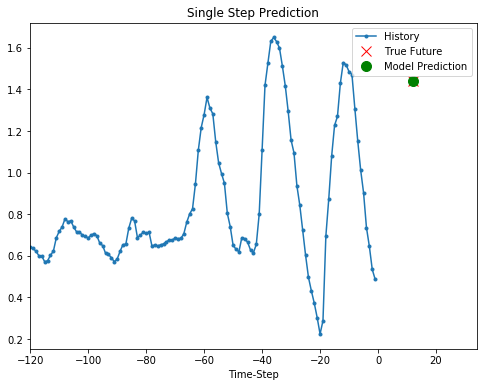

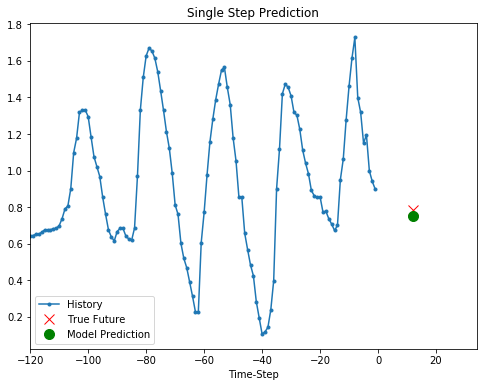

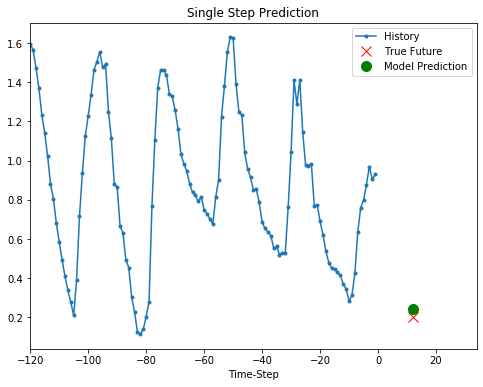

In [28]:
plot_preds(models[0], val_data_single)
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = random_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
#loss, accuracy = best_model.evaluate(x_val_single, y_val_single)